Guillaume Chaslot <guillaume.chaslot@data.gouv.fr>

# Tax Legislation Reform

The tax/benefit legislation is complex.

These tool help make reform that can simplify the tax benefit system.


### How it works:

1. Define your concepts (e.g., 'nb_enfants', 'age', 'parent isolé') and budget (e.g.: cost less than 2 millions euros)
2. The machine learning algorithm helps you adjust the parameters of your reform to approximate the current legislation and fit your budget
3. From the biggest discrepencies with the current legislation, you can improve your concepts (or the legislation)
4. Repeat until you reach a legislation that matches your own goals. The algorithm takes care of minimizing your budget and maximizing the similarity to current legislation.

### Beta version limitations:

For this test, we only take a population of people from all ages, who have 0 to 5 children, no salary, married, veuf, paces, divorces or celibataires, and simulate the "aides sociales"

### Current Results:

Within a few minutes, we got a tax reform for "aides sociales" for people with no salary that is:

* 6 lines long 
* similar to the existing in average at more than 95%


In [1]:
from utils import show_histogram, percent_diff, scatter_plot, multi_scatter
from econometrics import gini, draw_ginis

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import qgrid
import copy

from population_manager import PopulationManager
from reform_optimizer import ReformOptimizer

qgrid.nbinstall(overwrite=True)

%matplotlib inline

# TODO: move that in the reformator
def show_last_reform_results(revdisp, simulated_reform):
    if cost > 0:
        display_cost_name = 'Total Cost in Euros'
        display_cost_value = int(cost)
    else:
        display_cost_name = 'Total Savings in Euros'
        display_cost_value = -int(cost)

    old_gini = gini(revdisp)
    new_gini = gini(simulated_reform)

    result_frame = pd.DataFrame({
        display_cost_name: [display_cost_value],
        'Average change / family / month in Euros' : [int(error) / 12],
        'People losing money' : str(100 * pissed) + '%',
        'Old Gini' : old_gini,
        'New Gini' : new_gini,
        })

    result_frame.set_index(display_cost_name, inplace=True)
    qgrid.show_grid(result_frame)


Please provide one or several populations.


# Which population do we want to use?

For instance we want to use the 'revdisp' computed by OpenFisca, on a population that represents 0.21% of the french population.

In [2]:
pop_manager = PopulationManager(openfisca_results_filename='1aj-1bj-f-2000',
                                variables_loaded=['revdisp'],
                                echantillon=0.0021)

reformator = ReformOptimizer(population_manager=pop_manager,
                             target_variable='revdisp',
                             taxable_variable='taxable_variable')


# What are the concept you want to use for your reform?

You can add concepts like the number of children, age, family situation, etc... 

The input population is in the CERFA "declaration des revenus" format.

In [3]:

def age_dec_1(family):
    return age_from_box(family, '0DA')

def age_dec_2(family):
    if '0DB' in family:
        return age_from_box(family, '0DB')
    return None

def if_married(family):
    return 'M' in family

def if_pacse(family):
    return 'O' in family

def if_veuf(family):
    return 'V' in family

def if_divorce(family):
    return 'D' in family

def if_two_people(family):
    return '0DB' in family

def revenu_1(family):
    return family['1AJ']

def taxable_variable(family):
    if '1BJ' in family:
        return family['1AJ'] + family['1BJ']
    else:
        return family['1AJ']

def revenu_2(family):
    if '1BJ' in family:
        return family['1BJ']
    return False
    
def age_from_box(family, birthdate_box):
    return 2014 - family.get(birthdate_box, 2014)

def if_both_declarant_parent_below_24(family):
    if age_dec_1(family) >= 24:
        return False
    if '0DB' in family and age_dec_2(family) >= 24:
        return False
    if 'F' not in family or family['F'] == 0:
        return False
    return True

def per_child(family):
    if 'F' in family:
        return family['F']
    else:
        return None

def per_child_parent_isole(family):
    if '0DB' in family:
        return None
    if 'F' in family:
        return family['F']
    else:
        return None

def if_parent_isole_moins_20k(family):
    return 'F' in family and family['F'] >= 1 and ('0DB' not in family) and family['1AJ'] < 20000

def if_enfant_unique(family):
    return 'F' in family and family['F'] == 1

def if_deux_enfants_ou_plus(family):
    return 'F' in family and family['F'] >= 2

def per_child_after_2(family):
    if 'F' in family and family['F'] >= 2:
        return family['F'] - 2
    return None

def if_declarant_above_65(family):
    return age_from_box(family, '0DA') >= 65
    
def if_codeclarant_above_65(family):
    return '0DB' in family and age_from_box(family, '0DB') > 65

def per_declarant_above_65(family):
    return int(age_from_box(family, '0DB') >= 65) + int(age_from_box(family, '0DA') >= 65)

def per_declarant_above_24(family):
    return int(age_from_box(family, '0DB') >= 24) + int(age_from_box(family, '0DA') >= 24)

def if_one_declarant_above_24(family):
    return (age_from_box(family, '0DA') >= 24 or ('0DB' in family and age_from_box(family, '0DB') >= 24))

def if_one_declarant_above_24_or_has_children(family):
    return (age_from_box(family, '0DA') >= 24 or ('0DB' in family and age_from_box(family, '0DB') >= 24) or 
           ('F' in family and family['F'] >= 1))

def if_earns_10k(family):
    return taxable_variable(family) > 10000

def if_earns_30k(family):
    return taxable_variable(family) > 30000

def if_earns_40k(family):
    return taxable_variable(family) > 40000

def base(family):
    return True

pop_manager.add_concept('base', base)
pop_manager.add_concept('age_dec_1', age_dec_1)
pop_manager.add_concept('age_dec_2', age_dec_2)
pop_manager.add_concept('taxable_variable', taxable_variable)
pop_manager.add_concept('revenu_1', revenu_1)
pop_manager.add_concept('revenu_2', revenu_2)
pop_manager.add_concept('per_child', per_child)
pop_manager.add_concept('per_child_parent_isole', per_child_parent_isole)
pop_manager.add_concept('per_declarant_above_24', per_declarant_above_24)
pop_manager.add_concept('per_declarant_above_65', per_declarant_above_65)
pop_manager.add_concept('per_child_after_2', per_child_after_2)
pop_manager.add_concept('if_earns_10k', if_earns_10k)
pop_manager.add_concept('if_earns_30k', if_earns_30k)
pop_manager.add_concept('if_earns_40k', if_earns_40k)
pop_manager.add_concept('if_one_declarant_above_24', if_one_declarant_above_24)
pop_manager.add_concept('if_one_declarant_above_24_or_has_children', if_one_declarant_above_24_or_has_children)
pop_manager.add_concept('if_both_declarant_parent_below_24', if_both_declarant_parent_below_24)
pop_manager.add_concept('if_declarant_above_65', if_declarant_above_65)
pop_manager.add_concept('if_codeclarant_above_65', if_codeclarant_above_65)
pop_manager.add_concept('if_enfant_unique', if_enfant_unique)
pop_manager.add_concept('if_deux_enfants_ou_plus', if_deux_enfants_ou_plus)
pop_manager.add_concept('if_two_people', if_two_people)
pop_manager.add_concept('if_parent_isole_moins_20k', if_parent_isole_moins_20k)

pop_manager.summarize_population_from_cerfa_values()

Echantillon of 2863 people, in percent of french population for similar revenu: 0.009543333333333334%


# Plots Revenu disponible before reform

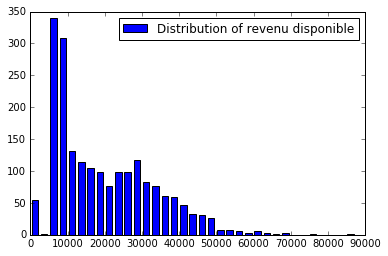

In [4]:
revdisp = list(family['revdisp'] for family in reformator._population_manager._population)
show_histogram(revdisp, 'Distribution of revenu disponible')


# <font color='red'>Define your reform here!</font>


In [5]:
simulated_reform, error, cost, final_parameters, pissed  = reformator.suggest_reform(
            parameters=[
                            'per_child',
                            'per_declarant_above_65',
                            'if_one_declarant_above_24_or_has_children',
                        ],
            tax_rate_parameters=[
                            'base',
                            'per_child',
            ],
            max_cost=0,
            min_saving=0)

['per_child', 'per_declarant_above_65', 'if_one_declarant_above_24_or_has_children']
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=625456, Wed Nov 30 15:08:58 2016)
Best: avg change per month: 69780 cost: -17513713 M/year and 79% people with lower salary
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.820903642613254e+02 1.0e+00 8.76e+03  8e+03  9e+03 0:0.1
    2     16 2.963686759456991e+02 1.1e+00 8.99e+03  8e+03  1e+04 0:0.2
    3     24 4.115566679951065e+03 1.3e+00 1.08e+04  1e+04  1e+04 0:0.3
Best: avg change per month: 40841 cost: -8321259 M/year and 55% people with lower salary
Best: avg change per month: 44331 cost: -10708282 M/year and 95% people with lower salary
Best: avg change per month: 21122 cost: -5312049 M/year and 97% people with lower salary
Best: avg change per month: 12105 cost: -1975325 M/year and 59% people with lower salary
Best: avg change per month: 16060 cost: -34068 M/year and 81% people with lower salary
Bes

In [6]:
show_last_reform_results(revdisp, simulated_reform)

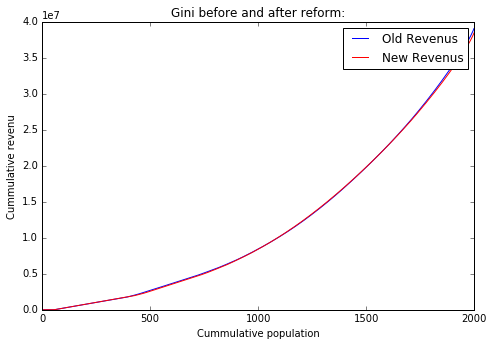

In [7]:
draw_ginis(revdisp, simulated_reform)

In [8]:
print repr(final_parameters)
def show_coefficients(final_parameters, current_type):
    coefficients = []
    variables = []
    for parameter in final_parameters:
        if parameter['type'] == current_type:
            coefficients.append(parameter['value'])
            variables.append(parameter['variable'])

    result_frame = pd.DataFrame({'Variables': variables, current_type + ' coef': coefficients})
    result_frame.set_index('Variables', inplace=True)
    qgrid.show_grid(result_frame)

show_coefficients(final_parameters, 'base_revenu')
show_coefficients(final_parameters, 'tax_rate')
# show_coefficients(final_parameters, 'tax_threshold')

[{'variable': 'per_declarant_above_65', 'type': 'base_revenu', 'value': 4375.7241011821843}, {'variable': 'if_one_declarant_above_24_or_has_children', 'type': 'base_revenu', 'value': 5242.081762554265}, {'variable': 'per_child', 'type': 'base_revenu', 'value': 2383.1659022492108}, {'variable': 'base', 'type': 'tax_rate', 'value': 18.57333094556202}, {'variable': 'per_child', 'type': 'tax_rate', 'value': -1.4885274050617538}]


In [11]:
new_pop = copy.deepcopy(reformator._population_manager._population)

for i in range(len(new_pop)):
    new_pop[i]['reform'] = simulated_reform[i] 

def plot_for_population(pop):
    revenu_imposable = list(family['taxable_variable'] for family in pop)
    revdisp = list(family['revdisp'] for family in pop)
    reform = list(family['reform'] for family in pop)

    multi_scatter('Revenu disponible for different people before / after reforme', 'Revenu initial', 'Revenu disponible', [
                  {'x':revenu_imposable, 'y':reform, 'label':'Reform', 'color':'blue'},
                  {'x':revenu_imposable, 'y':revdisp, 'label':'Original', 'color':'red'},
              ])

In [ ]:
un_enfant_pop = list(filter(lambda x: x.get('per_child', 0) == 0
                                  and x.get('age_dec_1', 0) < 65
                                  and x.get('age_dec_2', 0) < 65,
                            new_pop))

plot_for_population(un_enfant_pop)

In [ ]:
show_last_reform_results(revdisp, simulated_reform)

In [ ]:
# simulated_reform_tree, error_tree, cost_tree, final_parameters_tree  = reformator.suggest_reform_tree(
#             parameters=[
#                             'per_child',
#                             'if_one_declarant_above_24_or_has_children',
#                             'age_dec_1',
#                             'age_dec_2'
#                         ],
#                             max_cost=0,
#                             min_saving=0,
#                             image_file='./enfants_age',
#                             max_depth=5,
#                             min_samples_leaf=20
#                         )

# <font color="darkgreen">Reform results</font>

In [ ]:
# show_last_reform_results()
# from IPython.display import Image
# Image(filename='./enfants_age.png')

# Plots revenu disponible after reform

In [ ]:
xmin = 0
xmax = 60000
nb_buckets = 35

bins = np.linspace(xmin, xmax, nb_buckets)

plt.hist(revdisp, bins, alpha=0.5, label='current')
plt.hist(simulated_reform, bins, alpha=0.5, label='reform')
plt.legend(loc='upper right')
plt.show()

# Distribution of the changes in revenu in euros

In [ ]:
difference = list(simulated_reform[i] - revdisp[i] for i in range(len(simulated_reform)))

show_histogram(difference, 'Changes in revenu')

# Distribution of the change in revenu in percentage

In [ ]:
percentage_difference = list(100 * percent_diff(simulated_reform[i], revdisp[i]) for i in range(len(simulated_reform)))

show_histogram(percentage_difference, 'Changes in revenu')

# Change as a function of the number of children

In [ ]:
nb_children = list((reformator._population[i].get('per_child', 0)  for i in range(len(reformator._population)))) 

scatter_plot(nb_children, difference, 'Children', 'Difference reform - current', alpha=0.05)

# Change as a function of the age of declarant 1

A scatter plot is better than a thousand points #ChineseProverb

In [ ]:
age_dec1 = list((reformator._population[i].get('age_dec_1', 0)  for i in range(len(reformator._population)))) 

scatter_plot(age_dec1, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.1)

# <font color="Red">Most important: Edge Cases</font>

This is the heart of this tool: by seeing the worse cases, you can discover when the current legislation is smarter than yours (or the other way), and improve it further

In [ ]:
order = sorted(range(len(simulated_reform)), key=lambda k: -(simulated_reform[k] - revdisp[k]))

data = {}

possible_keys = set()
for i in order:
    for key in reformator._raw_population[i]:
        if key != 'year':
            possible_keys.add(key)

for i in order:
    # Adding the diff with the reform.
    differences = data.get('difference', [])
    differences.append(int(simulated_reform[i] - revdisp[i]))
    data['difference'] = differences

    for key in possible_keys:
        new_vals = data.get(key, [])
        value = reformator._raw_population[i].get(key, '')
        if type(value) == float:
            value = int(value)
        new_vals.append(value)
        data[key] = new_vals

    # Adding reformed line.
    reforms = data.get('reform', [])
    reforms.append(int(simulated_reform[i]))
    data['reform'] = reforms

df = pd.DataFrame(data=data)
df.set_index('difference', inplace=True)
qgrid.show_grid(df)


# Best compromise simplicity / matching current legislation:

In [ ]:
# res, error, cost, final_parameters = reformator.suggest_reform(parameters=[
#                             'if_one_declarant_above_24',
#                             'if_declarant_above_64',
#                             'if_codeclarant_above_64',
#                             'if_both_declarant_parent_below_24',
#                             'if_two_people',
#                             'if_enfant_unique',
#                             'if_deux_enfants_ou_plus',
#                             'nb_enfants_after_2',
#                            ])

In [ ]:
# coefficients = list(map(lambda x: x['value'], final_parameters)); variables = list(map(lambda x: x['variable'], final_parameters))
# result_frame = pd.DataFrame({'Variables': variables, 'Coefficient': coefficients})
# result_frame.set_index('Variables', inplace=True)
# qgrid.show_grid(result_frame)